In [10]:
#%pip install scikit-learn
#%pip install torch
#%pip install tqdm

In [11]:
# # 🦟 Predicción de Dengue con Perceptrón Multicapa (MLP) - PyTorch
# 
# **Objetivo:** Predecir casos de dengue por barrio usando datos temporales y ambientales con un modelo MLP implementado en PyTorch.
# 
# ---

# ## 📦 1. Importación y Configuración

# ### Librerías Principales
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import os
from tqdm import tqdm

# ### Configuración General
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuración de semillas para reproducibilidad
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Configuración del dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Usando dispositivo: {device}")

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Librerías importadas y configuración completada")

# ---

🔧 Usando dispositivo: cuda
✅ Librerías importadas y configuración completada


📊 Cargando datasets...
📈 Datos de entrenamiento: (3150, 20)
📉 Datos de prueba: (530, 20)
📋 Sample submission: (520, 2)

📋 INFORMACIÓN GENERAL DEL DATASET

🔢 Dimensiones del dataset de entrenamiento: (3150, 20)
🔢 Dimensiones del dataset de prueba: (530, 20)

📅 Rango temporal entrenamiento: 2015 - 2020
📅 Rango temporal prueba: 2021 - 2021

🏘️ Número de barrios únicos en entrenamiento: 10
🏘️ Número de barrios únicos en prueba: 10

📊 Columnas en entrenamiento: ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'dengue', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']
📊 Columnas en prueba: ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'dengue', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temper

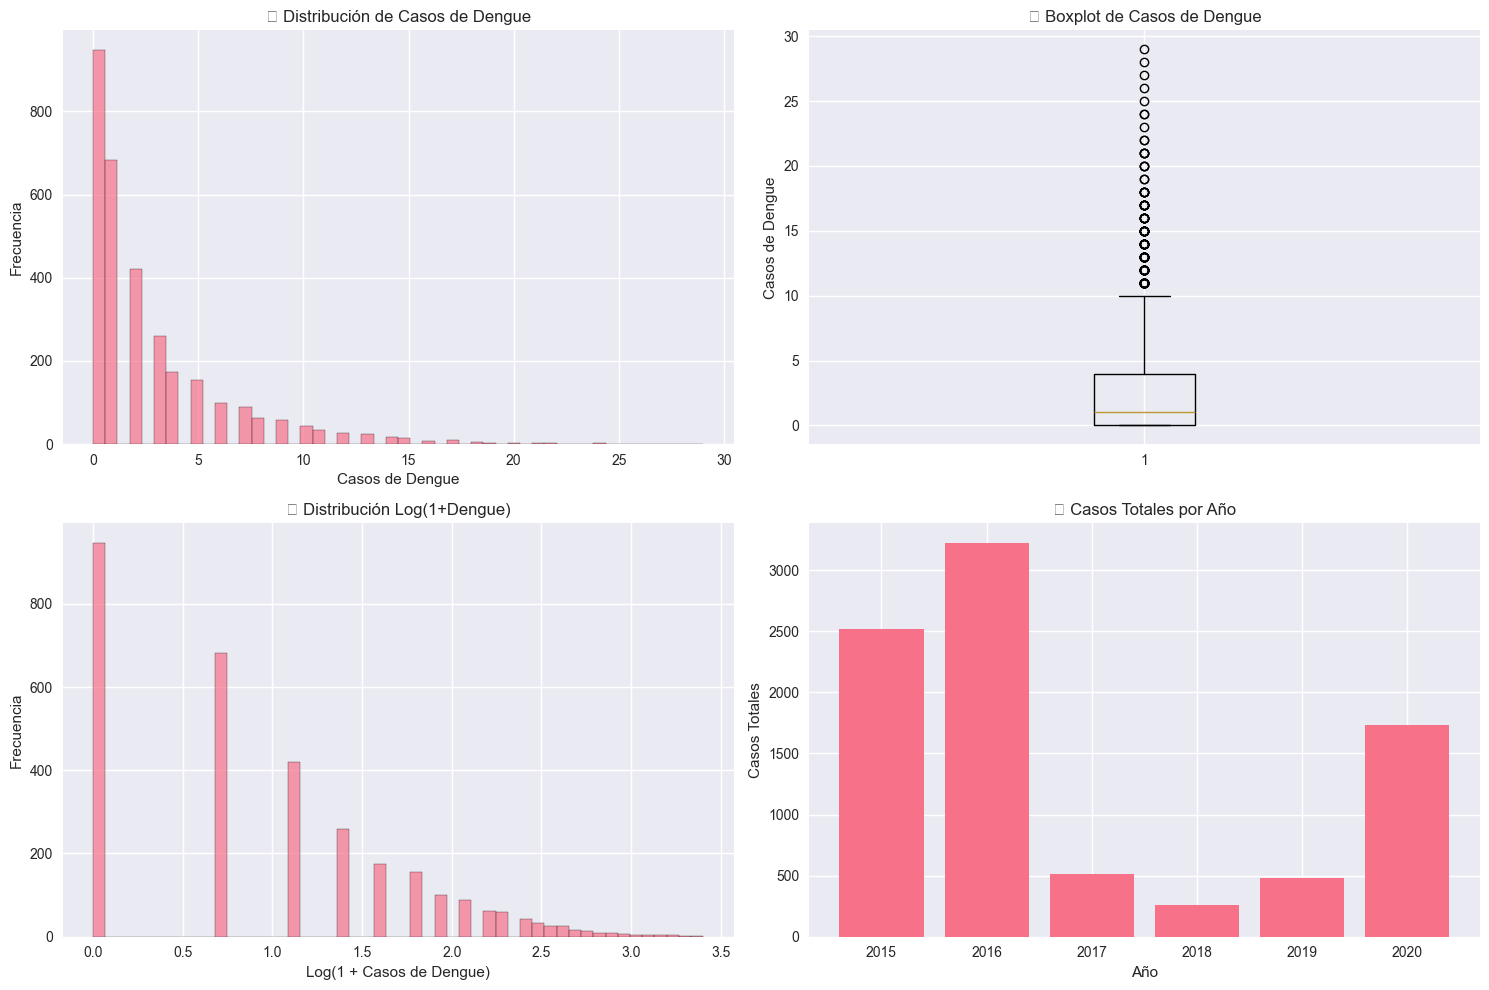


❌ ANÁLISIS DE VALORES NULOS
🔍 Valores nulos en entrenamiento:
Series([], dtype: int64)

🔍 Valores nulos en prueba:
Series([], dtype: int64)

🔗 MATRIZ DE CORRELACIÓN


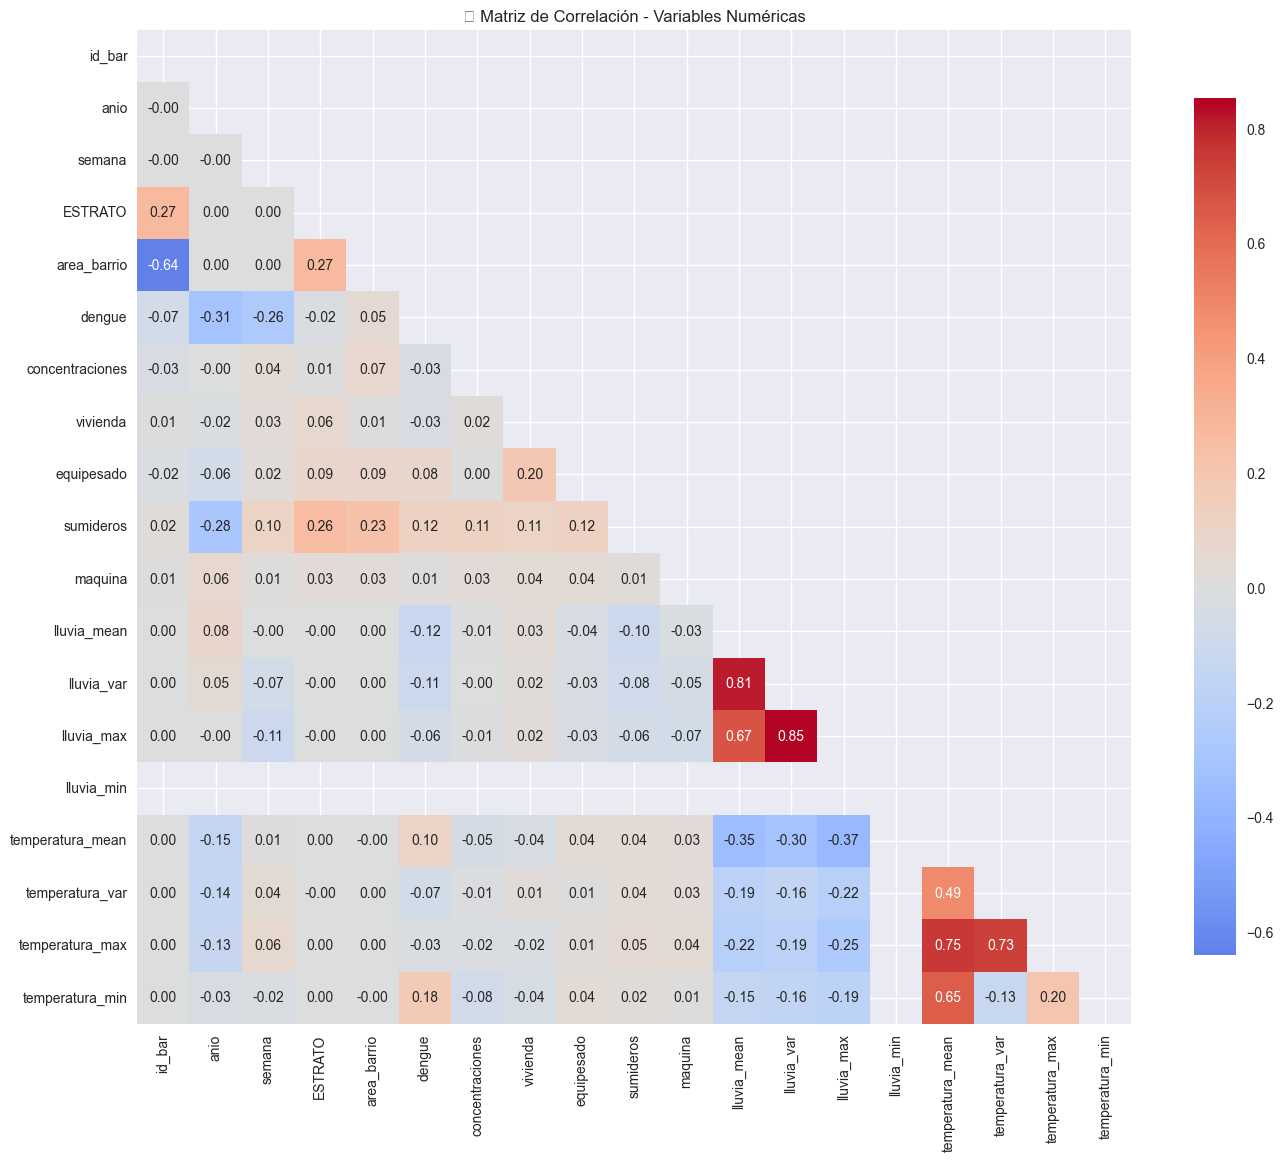


🎯 Variables más correlacionadas con dengue:
   • anio: 0.308
   • semana: 0.262
   • temperatura_min: 0.176
   • lluvia_mean: 0.124
   • sumideros: 0.121
   • lluvia_var: 0.106
   • temperatura_mean: 0.104
   • equipesado: 0.076
   • id_bar: 0.074


In [12]:
# ## 🔍 2. Exploración de Datos

# ### Carga de Datasets
print("📊 Cargando datasets...")

df = pd.read_parquet('../../Datos/df_train.parquet')
# Cargar datos de entrenamiento y prueba
df_train = df[df['anio']<=2020].copy() #pd.read_parquet('../../Datos/df_train.parquet')
df_test = df[df['anio']>=2021].copy()  #pd.read_parquet('../../Datos/df_test.parquet')
sample_submission = pd.read_csv('../../Datos/sample_submission.csv')

print(f"📈 Datos de entrenamiento: {df_train.shape}")
print(f"📉 Datos de prueba: {df_test.shape}")
print(f"📋 Sample submission: {sample_submission.shape}")

# ### Información General de los Datos
print("\n" + "="*50)
print("📋 INFORMACIÓN GENERAL DEL DATASET")
print("="*50)

print(f"\n🔢 Dimensiones del dataset de entrenamiento: {df_train.shape}")
print(f"🔢 Dimensiones del dataset de prueba: {df_test.shape}")

print(f"\n📅 Rango temporal entrenamiento: {df_train['anio'].min()} - {df_train['anio'].max()}")
print(f"📅 Rango temporal prueba: {df_test['anio'].min()} - {df_test['anio'].max()}")

print(f"\n🏘️ Número de barrios únicos en entrenamiento: {df_train['id_bar'].nunique()}")
print(f"🏘️ Número de barrios únicos en prueba: {df_test['id_bar'].nunique()}")

# ### Estructura de los Datos
print(f"\n📊 Columnas en entrenamiento: {list(df_train.columns)}")
print(f"📊 Columnas en prueba: {list(df_test.columns)}")

# Verificar tipos de datos
print(f"\n🔍 Tipos de datos:")
print(df_train.dtypes)

# ### Estadísticas Descriptivas
print(f"\n📈 ESTADÍSTICAS DESCRIPTIVAS")
print("="*50)
print(df_train.describe())

# ### Análisis de la Variable Objetivo
print(f"\n🎯 ANÁLISIS DE LA VARIABLE OBJETIVO (DENGUE)")
print("="*50)

print(f"📊 Estadísticas de casos de dengue:")
print(f"   • Media: {df_train['dengue'].mean():.2f}")
print(f"   • Mediana: {df_train['dengue'].median():.2f}")
print(f"   • Desviación estándar: {df_train['dengue'].std():.2f}")
print(f"   • Mínimo: {df_train['dengue'].min()}")
print(f"   • Máximo: {df_train['dengue'].max()}")
print(f"   • Casos con dengue > 0: {(df_train['dengue'] > 0).sum()} ({(df_train['dengue'] > 0).mean()*100:.1f}%)")

# ### Visualización de la Distribución de Dengue
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma de la variable objetivo
axes[0,0].hist(df_train['dengue'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('📊 Distribución de Casos de Dengue')
axes[0,0].set_xlabel('Casos de Dengue')
axes[0,0].set_ylabel('Frecuencia')

# Boxplot de la variable objetivo
axes[0,1].boxplot(df_train['dengue'])
axes[0,1].set_title('📦 Boxplot de Casos de Dengue')
axes[0,1].set_ylabel('Casos de Dengue')

# Distribución log transformada (agregamos 1 para evitar log(0))
log_dengue = np.log1p(df_train['dengue'])
axes[1,0].hist(log_dengue, bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_title('📊 Distribución Log(1+Dengue)')
axes[1,0].set_xlabel('Log(1 + Casos de Dengue)')
axes[1,0].set_ylabel('Frecuencia')

# Casos por año
yearly_cases = df_train.groupby('anio')['dengue'].sum()
axes[1,1].bar(yearly_cases.index, yearly_cases.values)
axes[1,1].set_title('📅 Casos Totales por Año')
axes[1,1].set_xlabel('Año')
axes[1,1].set_ylabel('Casos Totales')

plt.tight_layout()
plt.show()

# ### Análisis de Valores Nulos
print(f"\n❌ ANÁLISIS DE VALORES NULOS")
print("="*50)

missing_train = df_train.isnull().sum()
missing_test = df_test.isnull().sum()

print("🔍 Valores nulos en entrenamiento:")
print(missing_train[missing_train > 0])

print("\n🔍 Valores nulos en prueba:")
print(missing_test[missing_test > 0])

# Visualizar valores nulos
if missing_train.sum() > 0 or missing_test.sum() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training data missing values
    missing_train_pct = (missing_train / len(df_train)) * 100
    missing_train_pct = missing_train_pct[missing_train_pct > 0]
    if len(missing_train_pct) > 0:
        axes[0].bar(range(len(missing_train_pct)), missing_train_pct.values)
        axes[0].set_xticks(range(len(missing_train_pct)))
        axes[0].set_xticklabels(missing_train_pct.index, rotation=45)
        axes[0].set_title('❌ % Valores Nulos - Entrenamiento')
        axes[0].set_ylabel('Porcentaje')
    
    # Test data missing values  
    missing_test_pct = (missing_test / len(df_test)) * 100
    missing_test_pct = missing_test_pct[missing_test_pct > 0]
    if len(missing_test_pct) > 0:
        axes[1].bar(range(len(missing_test_pct)), missing_test_pct.values)
        axes[1].set_xticks(range(len(missing_test_pct)))
        axes[1].set_xticklabels(missing_test_pct.index, rotation=45)
        axes[1].set_title('❌ % Valores Nulos - Prueba')
        axes[1].set_ylabel('Porcentaje')
    
    plt.tight_layout()
    plt.show()

# ### Matriz de Correlación
print(f"\n🔗 MATRIZ DE CORRELACIÓN")
print("="*50)

# Seleccionar solo columnas numéricas para correlación
numeric_cols = df_train.select_dtypes(include=[np.number]).columns
correlation_matrix = df_train[numeric_cols].corr()

# Visualizar matriz de correlación
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('🔗 Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

# Correlaciones más altas con dengue
dengue_corr = correlation_matrix['dengue'].abs().sort_values(ascending=False)
print(f"\n🎯 Variables más correlacionadas con dengue:")
for var, corr in dengue_corr.head(10).items():
    if var != 'dengue':
        print(f"   • {var}: {corr:.3f}")

# ---

In [13]:
# ## 🔧 3. Preprocesamiento de Datos

print(f"\n🔧 PREPROCESAMIENTO DE DATOS")
print("="*50)

# ### Manejo de Valores Nulos
def handle_missing_values(df, strategy='median'):
    """
    Maneja valores nulos en el dataset
    
    Args:
        df: DataFrame a procesar
        strategy: estrategia para valores nulos ('median', 'mean', 'mode')
    
    Returns:
        DataFrame procesado
    """
    df_processed = df.copy()
    
    for col in df_processed.columns:
        if df_processed[col].isnull().sum() > 0:
            if df_processed[col].dtype in ['int64', 'float64']:
                if strategy == 'median':
                    fill_value = df_processed[col].median()
                elif strategy == 'mean':
                    fill_value = df_processed[col].mean()
                else:
                    fill_value = df_processed[col].mode()[0]
                df_processed[col].fillna(fill_value, inplace=True)
            else:
                # Para variables categóricas, usar moda
                fill_value = df_processed[col].mode()[0]
                df_processed[col].fillna(fill_value, inplace=True)
            
            print(f"   ✅ {col}: {df[col].isnull().sum()} valores nulos completados con {strategy}")
    
    return df_processed

# Aplicar manejo de valores nulos
df_train_clean = handle_missing_values(df_train, strategy='median')
df_test_clean = handle_missing_values(df_test, strategy='median')

print(f"✅ Valores nulos manejados")

# ### Ingeniería de Características

def create_features(df):
    """
    Crea nuevas características a partir de las variables existentes
    
    Args:
        df: DataFrame a procesar
        
    Returns:
        DataFrame con nuevas características
    """
    df_features = df.copy()
    
    # Características temporales
    df_features['semana_sin'] = np.sin(2 * np.pi * df_features['semana'] / 52)
    df_features['semana_cos'] = np.cos(2 * np.pi * df_features['semana'] / 52)
    
    # Interacciones entre variables climáticas
    df_features['lluvia_temp_interaction'] = df_features['lluvia_mean'] * df_features['temperatura_mean']
    df_features['lluvia_range'] = df_features['lluvia_max'] - df_features['lluvia_min']
    df_features['temp_range'] = df_features['temperatura_max'] - df_features['temperatura_min']
    
    # Características derivadas de equipamiento
    df_features['equipamiento_total'] = df_features['equipesado'] + df_features['maquina']
    
    # Ratios
    if 'area_barrio' in df_features.columns:
        df_features['vivienda_per_area'] = df_features['vivienda'] / (df_features['area_barrio'] + 1e-8)
        df_features['concentraciones_per_area'] = df_features['concentraciones'] / (df_features['area_barrio'] + 1e-8)
    
    print(f"   ✅ Creadas {len([col for col in df_features.columns if col not in df.columns])} nuevas características")
    
    return df_features

# Aplicar ingeniería de características
df_train_features = create_features(df_train_clean)
df_test_features = create_features(df_test_clean)

print(f"✅ Ingeniería de características completada")

# ### Encoding de Variables Categóricas
label_encoders = {}

# Identificar variables categóricas (si las hay)
categorical_columns = df_train_features.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col not in ['id']]

if len(categorical_columns) > 0:
    for col in categorical_columns:
        le = LabelEncoder()
        
        # Combinar valores únicos de train y test para fitting
        combined_values = pd.concat([df_train_features[col], df_test_features[col]]).unique()
        le.fit(combined_values)
        
        df_train_features[col] = le.transform(df_train_features[col])
        df_test_features[col] = le.transform(df_test_features[col])
        
        label_encoders[col] = le
        print(f"   ✅ {col}: {len(combined_values)} categorías codificadas")

print(f"✅ Variables categóricas codificadas")

# ### Preparación de Features y Target

# Definir columnas de características (excluir id, anio en algunos casos según necesidad)
feature_columns = [col for col in df_train_features.columns 
                  if col not in ['id', 'dengue', '__index_level_0__']]

X_train = df_train_features[feature_columns].values
y_train = df_train_features['dengue'].values
X_test = df_test_features[feature_columns].values

print(f"📊 Dimensiones finales:")
print(f"   • X_train: {X_train.shape}")
print(f"   • y_train: {y_train.shape}")
print(f"   • X_test: {X_test.shape}")

# ### División Train/Validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=None
)

print(f"📊 División train/validation:")
print(f"   • Entrenamiento: {X_train_split.shape[0]} muestras")
print(f"   • Validación: {X_val_split.shape[0]} muestras")

# ### Normalización de Datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Datos normalizados con StandardScaler")

# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_split).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val_split).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

print(f"✅ Datos convertidos a tensores de PyTorch")

# ### Crear DataLoaders
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ DataLoaders creados (batch_size={batch_size})")

print(f"\n📋 Características utilizadas ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"   {i:2d}. {col}")

# ---


🔧 PREPROCESAMIENTO DE DATOS
✅ Valores nulos manejados
   ✅ Creadas 8 nuevas características
   ✅ Creadas 8 nuevas características
✅ Ingeniería de características completada
✅ Variables categóricas codificadas
📊 Dimensiones finales:
   • X_train: (3150, 26)
   • y_train: (3150,)
   • X_test: (530, 26)
📊 División train/validation:
   • Entrenamiento: 2520 muestras
   • Validación: 630 muestras
✅ Datos normalizados con StandardScaler
✅ Datos convertidos a tensores de PyTorch
✅ DataLoaders creados (batch_size=64)

📋 Características utilizadas (26):
    1. id_bar
    2. anio
    3. semana
    4. ESTRATO
    5. area_barrio
    6. concentraciones
    7. vivienda
    8. equipesado
    9. sumideros
   10. maquina
   11. lluvia_mean
   12. lluvia_var
   13. lluvia_max
   14. lluvia_min
   15. temperatura_mean
   16. temperatura_var
   17. temperatura_max
   18. temperatura_min
   19. semana_sin
   20. semana_cos
   21. lluvia_temp_interaction
   22. lluvia_range
   23. temp_range
   24. equipam

In [14]:
 ## 🧠 4. Arquitectura del MLP

print(f"\n🧠 DEFINICIÓN DE LA ARQUITECTURA MLP")
print("="*50)

class DengueMLP(nn.Module):
    """
    Perceptrón Multicapa para predicción de casos de dengue
    
    Arquitectura:
    - Capa de entrada: tamaño de features
    - 3 capas ocultas con activación ReLU y Dropout
    - Capa de salida: 1 neurona (regresión)
    - Batch Normalization para estabilizar entrenamiento
    """
    
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.3):
        super(DengueMLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.dropout_rate = dropout_rate
        
        # Capas de la red
        layers = []
        
        # Primera capa oculta
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        # Capas ocultas intermedias
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.BatchNorm1d(hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # Capa de salida
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        self.network = nn.Sequential(*layers)
        
        # Inicialización de pesos
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Inicialización Xavier/Glorot para mejor convergencia"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.network(x).squeeze()
    
    def get_architecture_info(self):
        """Retorna información sobre la arquitectura del modelo"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        info = {
            'input_size': self.input_size,
            'hidden_sizes': self.hidden_sizes,
            'dropout_rate': self.dropout_rate,
            'total_parameters': total_params,
            'trainable_parameters': trainable_params
        }
        return info

# Crear modelo
input_size = X_train_scaled.shape[1]
model = DengueMLP(
    input_size=input_size,
    hidden_sizes=[128, 64, 32],  # Arquitectura de 3 capas ocultas
    dropout_rate=0.3
).to(device)

# Información del modelo
arch_info = model.get_architecture_info()
print(f"🏗️ ARQUITECTURA DEL MODELO:")
print(f"   • Tamaño de entrada: {arch_info['input_size']}")
print(f"   • Capas ocultas: {arch_info['hidden_sizes']}")
print(f"   • Dropout rate: {arch_info['dropout_rate']}")
print(f"   • Parámetros totales: {arch_info['total_parameters']:,}")
print(f"   • Parámetros entrenables: {arch_info['trainable_parameters']:,}")

# Mostrar arquitectura completa
print(f"\n📋 ESTRUCTURA DETALLADA:")
print(model)

# Función para calcular el tamaño de salida de cada capa
def calculate_output_sizes(model, input_size):
    """Calcula y muestra los tamaños de salida de cada capa"""
    print(f"\n📐 TAMAÑOS DE CAPAS:")
    dummy_input = torch.randn(1, input_size).to(device)
    
    with torch.no_grad():
        x = dummy_input
        for i, layer in enumerate(model.network):
            x = layer(x)
            if isinstance(layer, (nn.Linear, nn.ReLU, nn.Dropout, nn.BatchNorm1d)):
                print(f"   Capa {i+1:2d} ({layer.__class__.__name__:>12}): {x.shape[1:]} -> {x.numel()} parámetros")



print(f"✅ Modelo creado y listo para entrenamiento")

# ---


🧠 DEFINICIÓN DE LA ARQUITECTURA MLP
🏗️ ARQUITECTURA DEL MODELO:
   • Tamaño de entrada: 26
   • Capas ocultas: [128, 64, 32]
   • Dropout rate: 0.3
   • Parámetros totales: 14,273
   • Parámetros entrenables: 14,273

📋 ESTRUCTURA DETALLADA:
DengueMLP(
  (network): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)
✅ Modelo creado y listo para entrenamie

In [15]:
#calculate_output_sizes(model, input_size)

In [16]:
#

# ## 🏋️ 5. Entrenamiento del Modelo

print(f"\n🏋️ CONFIGURACIÓN Y ENTRENAMIENTO DEL MODELO")
print("="*50)

# ### Configuración de Entrenamiento
learning_rate = 0.001
num_epochs = 300
patience = 50  # Para early stopping

# Función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=7, factor=0.5)

print(f"⚙️ Configuración de entrenamiento:")
print(f"   • Función de pérdida: MSE (Mean Squared Error)")
print(f"   • Optimizador: Adam (lr={learning_rate}, weight_decay=1e-5)")
print(f"   • Scheduler: ReduceLROnPlateau")
print(f"   • Épocas máximas: {num_epochs}")
print(f"   • Early stopping patience: {patience}")

# ### Funciones de Evaluación
def calculate_metrics(y_true, y_pred):
    """Calcula métricas de evaluación"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

def evaluate_model(model, data_loader, criterion, device):
    """Evalúa el modelo en un conjunto de datos"""
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    metrics = calculate_metrics(actuals, predictions)
    
    return avg_loss, metrics, np.array(predictions), np.array(actuals)

# ### Entrenamiento con Early Stopping
print(f"\n🚀 Iniciando entrenamiento...")

# Listas para almacenar métricas de entrenamiento
train_losses = []
val_losses = []
train_metrics_history = []
val_metrics_history = []

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

# Barra de progreso
pbar = tqdm(range(num_epochs), desc="Entrenando")

for epoch in pbar:
    # Modo entrenamiento
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Calcular pérdida promedio de entrenamiento
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluación en validación
    val_loss, val_metrics, val_preds, val_actuals = evaluate_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_metrics_history.append(val_metrics)
    
    # Evaluación en entrenamiento (muestra)
    train_loss_eval, train_metrics, _, _ = evaluate_model(model, train_loader, criterion, device)
    train_metrics_history.append(train_metrics)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    # Actualizar barra de progreso
    pbar.set_postfix({
        'Train Loss': f'{avg_train_loss:.4f}',
        'Val Loss': f'{val_loss:.4f}',
        'Val R²': f'{val_metrics["R²"]:.4f}',
        'Patience': f'{patience_counter}/{patience}'
    })
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⏰ Early stopping en época {epoch+1}")
        break

# Cargar el mejor modelo
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Mejor modelo cargado (validación loss: {best_val_loss:.4f})")

print(f"🏁 Entrenamiento completado")

# ### Guardar Modelo
model_path = 'dengue_mlp_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'feature_columns': feature_columns,
    'model_config': arch_info,
    'label_encoders': label_encoders
}, model_path)

print(f"💾 Modelo guardado en: {model_path}")

# ---


🏋️ CONFIGURACIÓN Y ENTRENAMIENTO DEL MODELO
⚙️ Configuración de entrenamiento:
   • Función de pérdida: MSE (Mean Squared Error)
   • Optimizador: Adam (lr=0.001, weight_decay=1e-5)
   • Scheduler: ReduceLROnPlateau
   • Épocas máximas: 300
   • Early stopping patience: 50

🚀 Iniciando entrenamiento...


Entrenando:  76%|███████▌  | 228/300 [00:41<00:13,  5.51it/s, Train Loss=5.8912, Val Loss=5.5810, Val R²=0.5817, Patience=50/50]


⏰ Early stopping en época 229
✅ Mejor modelo cargado (validación loss: 5.5629)
🏁 Entrenamiento completado
💾 Modelo guardado en: dengue_mlp_model.pth



📈 EVALUACIÓN Y VALIDACIÓN DEL MODELO
📊 MÉTRICAS FINALES:

🏋️ Entrenamiento:
   • MSE: 3.9201
   • RMSE: 1.9799
   • MAE: 1.3067
   • R²: 0.7170

✅ Validación:
   • MSE: 5.5698
   • RMSE: 2.3600
   • MAE: 1.4705
   • R²: 0.5817


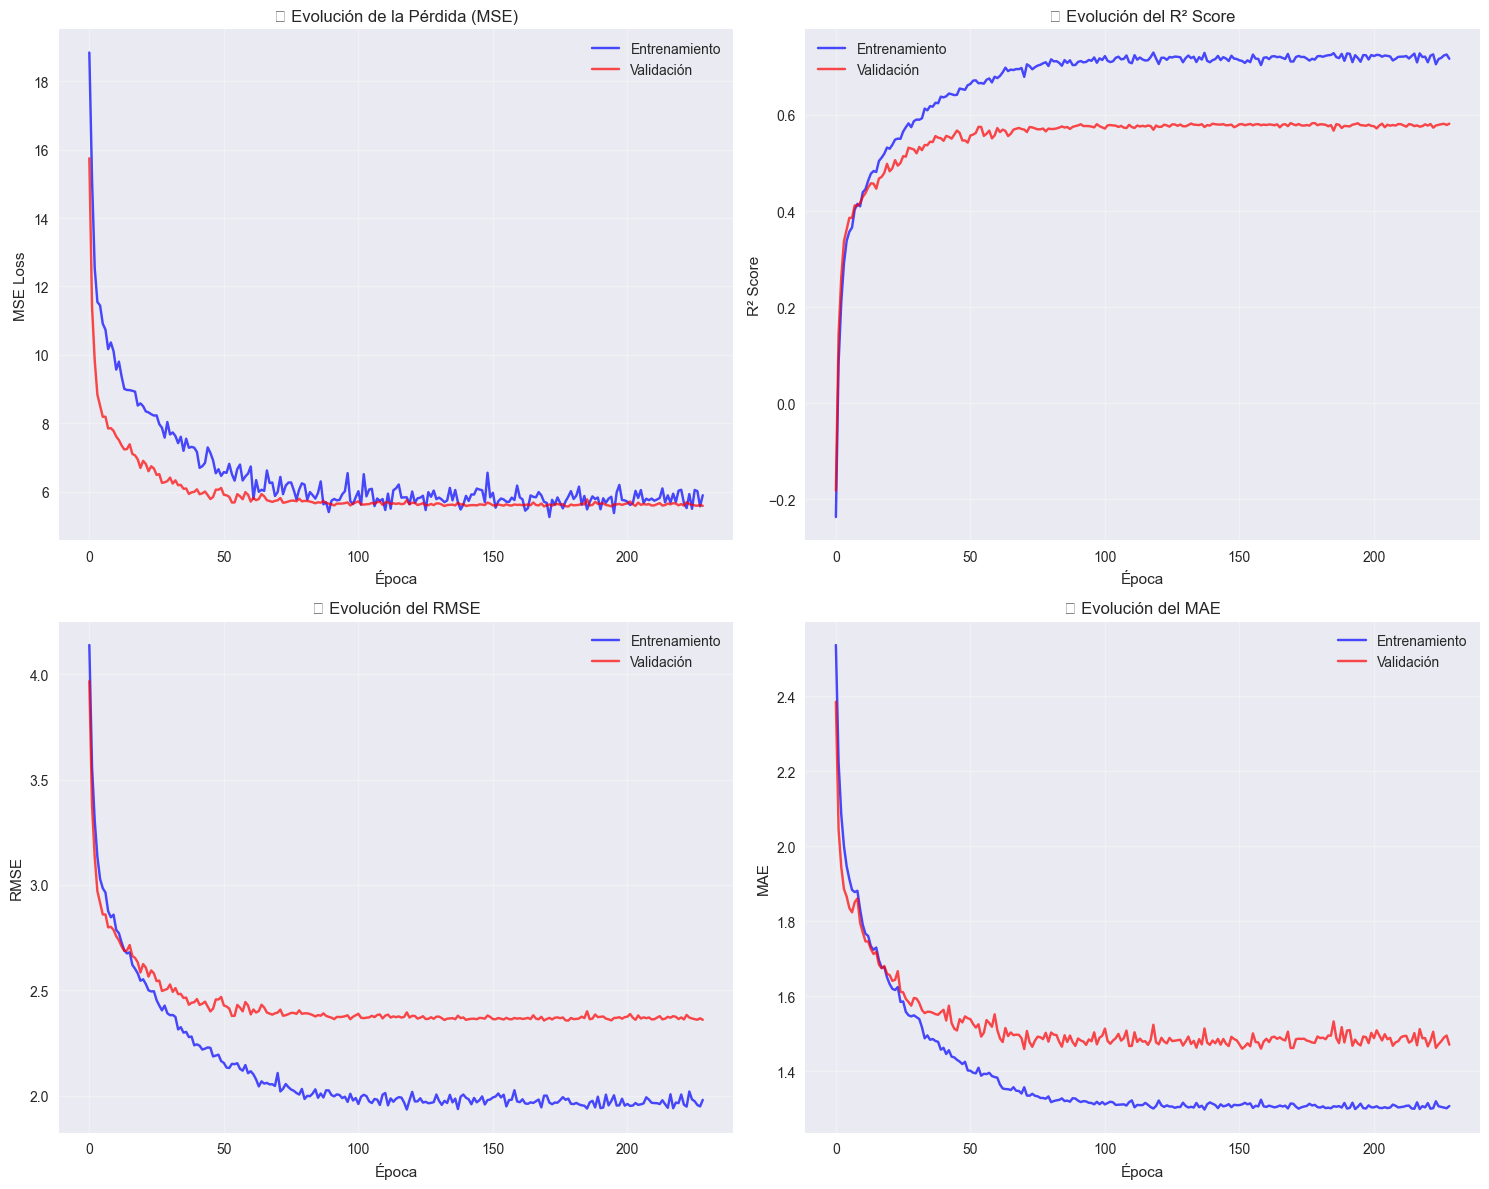

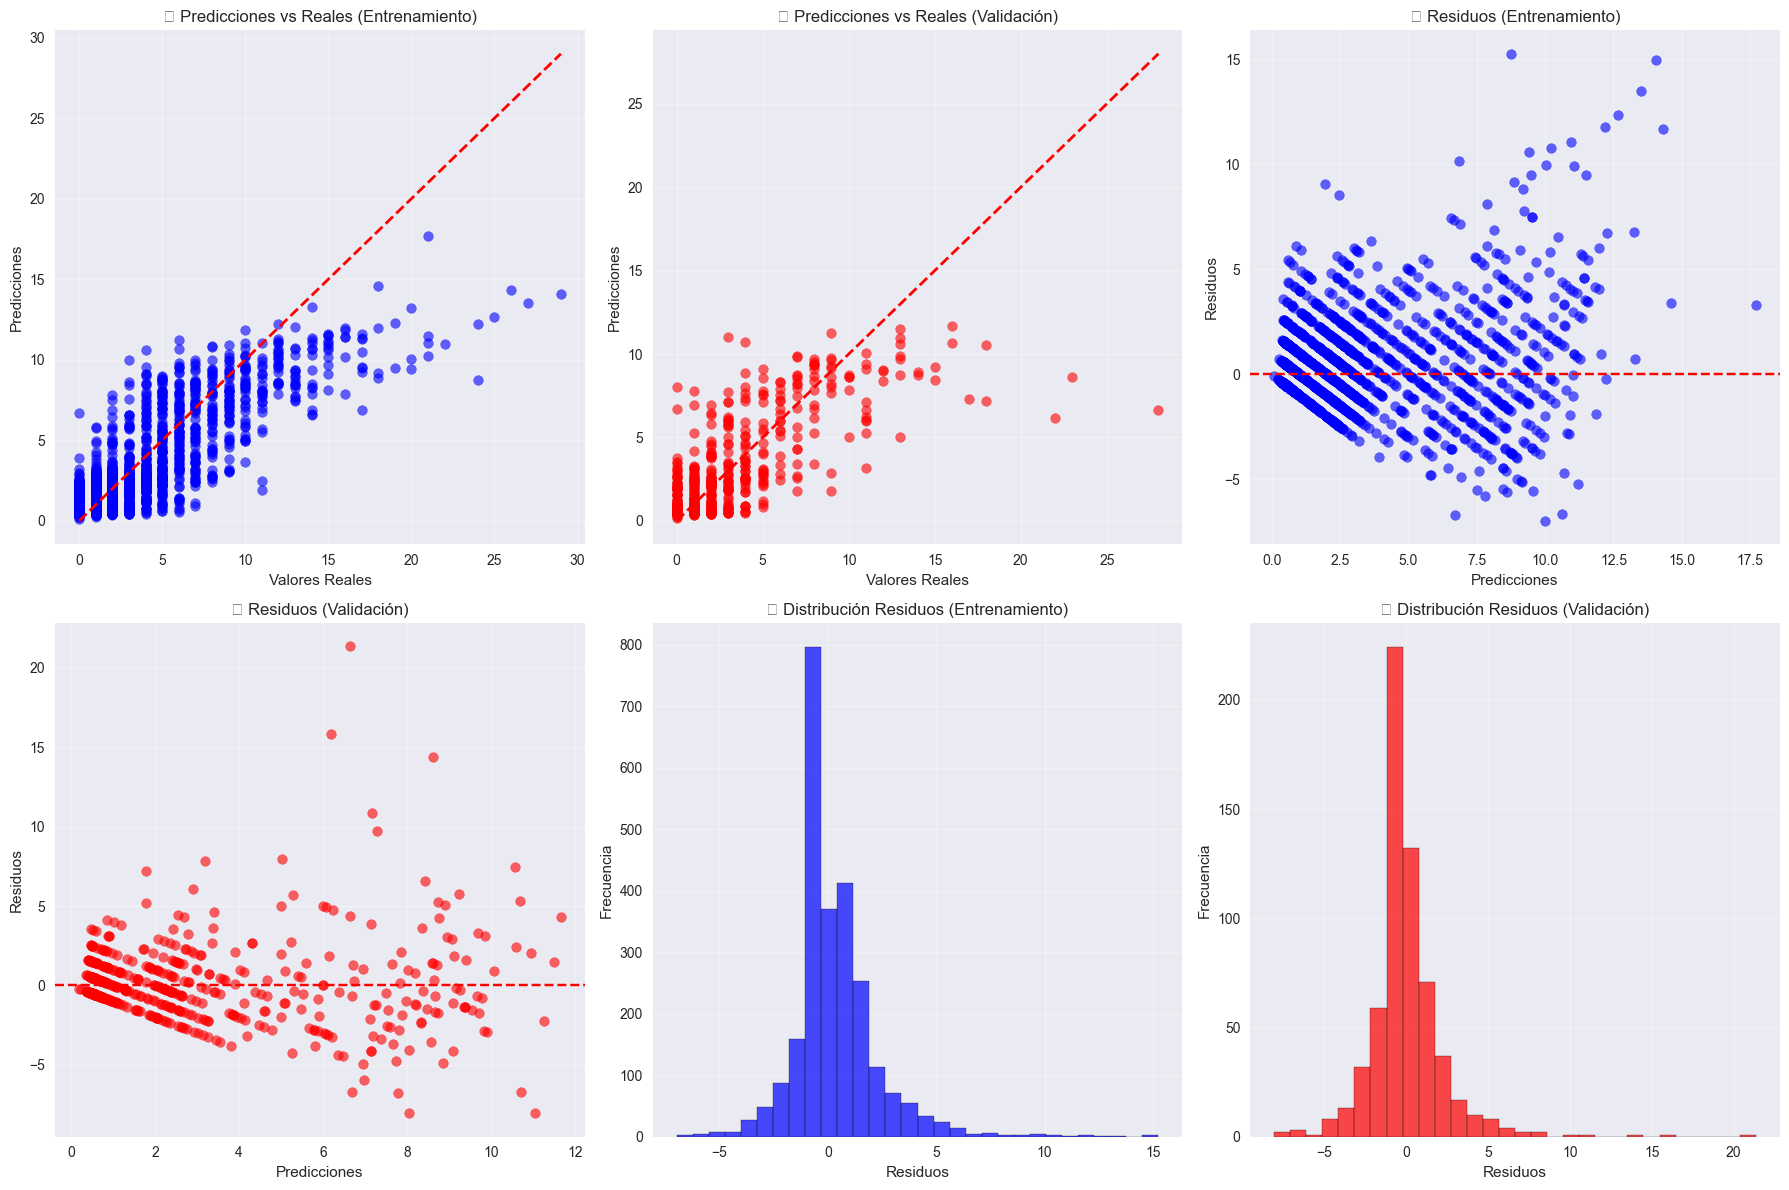


🔄 VALIDACIÓN CRUZADA (K-FOLD)
🔄 Realizando validación cruzada...
   Fold 1/5... R² = 0.2403
   Fold 2/5... R² = 0.1481
   Fold 3/5... R² = -0.0227
   Fold 4/5... R² = 0.0303
   Fold 5/5... R² = 0.1285

📊 Resultados de Validación Cruzada:
   • R² promedio: 0.1049 ± 0.0923
   • R² mínimo: -0.0227
   • R² máximo: 0.2403


In [17]:
# ## 📈 6. Evaluación y Validación

print(f"\n📈 EVALUACIÓN Y VALIDACIÓN DEL MODELO")
print("="*50)

# ### Evaluación Final
# Evaluación en entrenamiento
train_loss_final, train_metrics_final, train_preds_final, train_actuals_final = evaluate_model(
    model, train_loader, criterion, device
)

# Evaluación en validación
val_loss_final, val_metrics_final, val_preds_final, val_actuals_final = evaluate_model(
    model, val_loader, criterion, device
)

print(f"📊 MÉTRICAS FINALES:")
print(f"\n🏋️ Entrenamiento:")
for metric, value in train_metrics_final.items():
    print(f"   • {metric}: {value:.4f}")

print(f"\n✅ Validación:")
for metric, value in val_metrics_final.items():
    print(f"   • {metric}: {value:.4f}")

# ### Visualización de Pérdidas de Entrenamiento
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Pérdidas
axes[0,0].plot(train_losses, label='Entrenamiento', color='blue', alpha=0.7)
axes[0,0].plot(val_losses, label='Validación', color='red', alpha=0.7)
axes[0,0].set_title('📉 Evolución de la Pérdida (MSE)')
axes[0,0].set_xlabel('Época')
axes[0,0].set_ylabel('MSE Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# R² Score
train_r2_history = [metrics['R²'] for metrics in train_metrics_history]
val_r2_history = [metrics['R²'] for metrics in val_metrics_history]

axes[0,1].plot(train_r2_history, label='Entrenamiento', color='blue', alpha=0.7)
axes[0,1].plot(val_r2_history, label='Validación', color='red', alpha=0.7)
axes[0,1].set_title('📈 Evolución del R² Score')
axes[0,1].set_xlabel('Época')
axes[0,1].set_ylabel('R² Score')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# RMSE
train_rmse_history = [metrics['RMSE'] for metrics in train_metrics_history]
val_rmse_history = [metrics['RMSE'] for metrics in val_metrics_history]

axes[1,0].plot(train_rmse_history, label='Entrenamiento', color='blue', alpha=0.7)
axes[1,0].plot(val_rmse_history, label='Validación', color='red', alpha=0.7)
axes[1,0].set_title('📊 Evolución del RMSE')
axes[1,0].set_xlabel('Época')
axes[1,0].set_ylabel('RMSE')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# MAE
train_mae_history = [metrics['MAE'] for metrics in train_metrics_history]
val_mae_history = [metrics['MAE'] for metrics in val_metrics_history]

axes[1,1].plot(train_mae_history, label='Entrenamiento', color='blue', alpha=0.7)
axes[1,1].plot(val_mae_history, label='Validación', color='red', alpha=0.7)
axes[1,1].set_title('📏 Evolución del MAE')
axes[1,1].set_xlabel('Época')
axes[1,1].set_ylabel('MAE')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ### Análisis de Residuos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Predicciones vs Valores Reales - Entrenamiento
axes[0,0].scatter(train_actuals_final, train_preds_final, alpha=0.6, color='blue')
axes[0,0].plot([train_actuals_final.min(), train_actuals_final.max()], 
               [train_actuals_final.min(), train_actuals_final.max()], 'r--', lw=2)
axes[0,0].set_title('🎯 Predicciones vs Reales (Entrenamiento)')
axes[0,0].set_xlabel('Valores Reales')
axes[0,0].set_ylabel('Predicciones')
axes[0,0].grid(True, alpha=0.3)

# Predicciones vs Valores Reales - Validación
axes[0,1].scatter(val_actuals_final, val_preds_final, alpha=0.6, color='red')
axes[0,1].plot([val_actuals_final.min(), val_actuals_final.max()], 
               [val_actuals_final.min(), val_actuals_final.max()], 'r--', lw=2)
axes[0,1].set_title('🎯 Predicciones vs Reales (Validación)')
axes[0,1].set_xlabel('Valores Reales')
axes[0,1].set_ylabel('Predicciones')
axes[0,1].grid(True, alpha=0.3)

# Residuos - Entrenamiento
train_residuals = train_actuals_final - train_preds_final
axes[0,2].scatter(train_preds_final, train_residuals, alpha=0.6, color='blue')
axes[0,2].axhline(y=0, color='r', linestyle='--')
axes[0,2].set_title('📊 Residuos (Entrenamiento)')
axes[0,2].set_xlabel('Predicciones')
axes[0,2].set_ylabel('Residuos')
axes[0,2].grid(True, alpha=0.3)

# Residuos - Validación
val_residuals = val_actuals_final - val_preds_final
axes[1,0].scatter(val_preds_final, val_residuals, alpha=0.6, color='red')
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_title('📊 Residuos (Validación)')
axes[1,0].set_xlabel('Predicciones')
axes[1,0].set_ylabel('Residuos')
axes[1,0].grid(True, alpha=0.3)

# Histograma de Residuos - Entrenamiento
axes[1,1].hist(train_residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[1,1].set_title('📊 Distribución Residuos (Entrenamiento)')
axes[1,1].set_xlabel('Residuos')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].grid(True, alpha=0.3)

# Histograma de Residuos - Validación
axes[1,2].hist(val_residuals, bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1,2].set_title('📊 Distribución Residuos (Validación)')
axes[1,2].set_xlabel('Residuos')
axes[1,2].set_ylabel('Frecuencia')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ### Validación Cruzada (Opcional - para mayor robustez)
print(f"\n🔄 VALIDACIÓN CRUZADA (K-FOLD)")
print("="*50)

def cross_validate_model(X, y, k_folds=5):
    """Realiza validación cruzada K-fold"""
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_SEED)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"   Fold {fold + 1}/{k_folds}...", end=" ")
        
        # División de datos
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        
        # Escalado
        scaler_cv = StandardScaler()
        X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
        X_val_cv_scaled = scaler_cv.transform(X_val_cv)
        
        # Convertir a tensores
        X_train_cv_tensor = torch.FloatTensor(X_train_cv_scaled).to(device)
        y_train_cv_tensor = torch.FloatTensor(y_train_cv).to(device)
        X_val_cv_tensor = torch.FloatTensor(X_val_cv_scaled).to(device)
        y_val_cv_tensor = torch.FloatTensor(y_val_cv).to(device)
        
        # Crear modelo para este fold
        model_cv = DengueMLP(input_size=X.shape[1], hidden_sizes=[128, 64, 32], dropout_rate=0.3).to(device)
        optimizer_cv = optim.Adam(model_cv.parameters(), lr=0.001, weight_decay=1e-5)
        criterion_cv = nn.MSELoss()
        
        # Entrenar por pocas épocas para CV
        for epoch in range(50):
            model_cv.train()
            optimizer_cv.zero_grad()
            outputs = model_cv(X_train_cv_tensor)
            loss = criterion_cv(outputs, y_train_cv_tensor)
            loss.backward()
            optimizer_cv.step()
        
        # Evaluar
        model_cv.eval()
        with torch.no_grad():
            val_outputs = model_cv(X_val_cv_tensor)
            val_r2 = r2_score(y_val_cv, val_outputs.cpu().numpy())
            cv_scores.append(val_r2)
        
        print(f"R² = {val_r2:.4f}")
    
    return cv_scores

# Realizar validación cruzada (comentar si es muy lento)
print("🔄 Realizando validación cruzada...")
cv_scores = cross_validate_model(X_train, y_train, k_folds=5)

print(f"\n📊 Resultados de Validación Cruzada:")
print(f"   • R² promedio: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"   • R² mínimo: {np.min(cv_scores):.4f}")
print(f"   • R² máximo: {np.max(cv_scores):.4f}")

# ---


🔮 GENERACIÓN DE PREDICCIONES FINALES
🧠 Generando predicciones en el conjunto de prueba...
✅ Predicciones generadas: 530
📊 Estadísticas de predicciones:
   • Media: 3.76
   • Mediana: 2.77
   • Mínimo: 0.36
   • Máximo: 12.23
   • Desviación estándar: 2.67

📋 Verificando formato de submission:
   • Columnas: ['id', 'dengue']
   • Shape: (530, 2)
   • Tipos de datos:
id         object
dengue    float32
dtype: object
💾 Archivo de submission guardado: dengue_mlp_submission.csv

👀 Primeras 10 predicciones:
             id    dengue
3150  4_2021_01  5.528236
3151  5_2021_01  4.641819
3152  3_2021_01  5.407630
3153  8_2021_01  4.358715
3154  9_2021_01  4.114575
3155  2_2021_01  5.912463
3156  6_2021_01  4.936693
3157  1_2021_01  6.626195
3158  7_2021_01  3.908848
3159  0_2021_01  5.721313


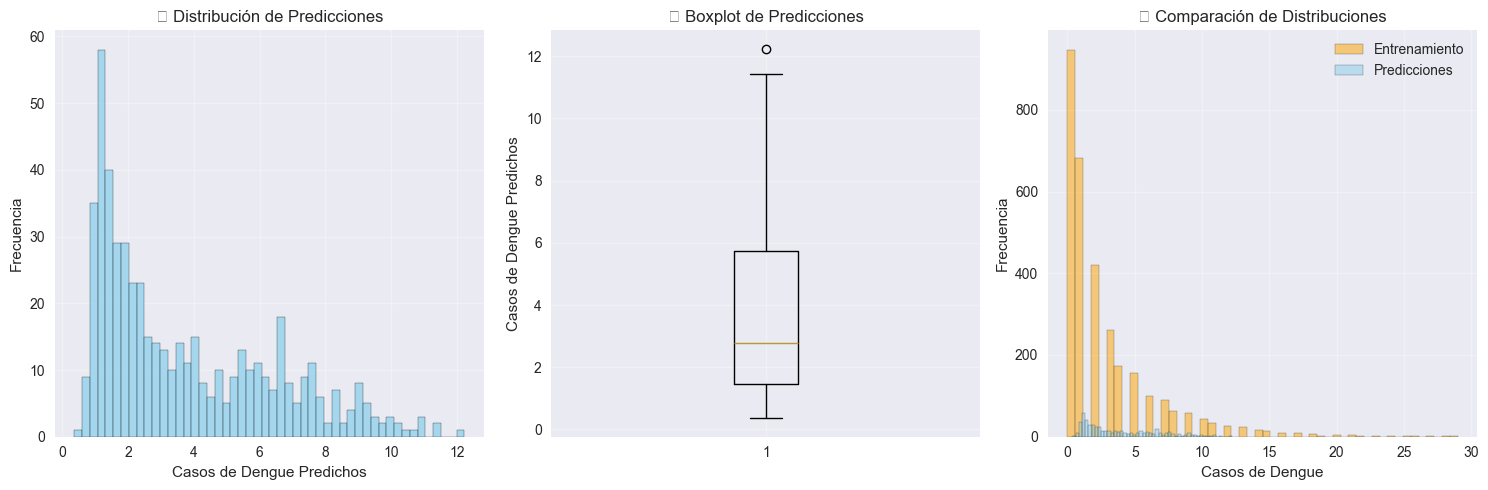


📊 ANÁLISIS FINAL DE RESULTADOS
🏆 RESUMEN DEL RENDIMIENTO DEL MODELO:
   • Arquitectura: [128, 64, 32] (dropout: 0.3)
   • Parámetros totales: 14,273
   • Características utilizadas: 26

📈 Métricas de Entrenamiento:
   • MSE: 3.9201
   • RMSE: 1.9799
   • MAE: 1.3067
   • R²: 0.7170

✅ Métricas de Validación:
   • MSE: 5.5698
   • RMSE: 2.3600
   • MAE: 1.4705
   • R²: 0.5817

🎯 Validación Cruzada:
   • R² CV promedio: 0.1049 ± 0.0923

🔍 ANÁLISIS DE CARACTERÍSTICAS:
🏅 Top 10 características más correlacionadas:
    1. anio: 0.308
    2. semana: 0.262
    3. lluvia_min: nan
    4. semana_sin: 0.303
    5. temperatura_min: 0.176
    6. temp_range: 0.147
    7. lluvia_mean: 0.124
    8. lluvia_temp_interaction: 0.122
    9. sumideros: 0.121
   10. lluvia_var: 0.106

⚠️ LIMITACIONES DEL MODELO:
   • El modelo asume relaciones no lineales complejas entre variables
   • La predicción está limitada por la calidad de los datos de entrada
   • Factores estacionales y cíclicos podrían requerir m

In [18]:
# ## 🔮 7. Predicciones Finales

print(f"\n🔮 GENERACIÓN DE PREDICCIONES FINALES")
print("="*50)

# ### Predicciones en el conjunto de prueba
model.eval()
test_predictions = []

print("🧠 Generando predicciones en el conjunto de prueba...")

with torch.no_grad():
    for i in range(0, len(X_test_tensor), batch_size):
        batch_end = min(i + batch_size, len(X_test_tensor))
        batch_X = X_test_tensor[i:batch_end]
        batch_pred = model(batch_X)
        test_predictions.extend(batch_pred.cpu().numpy())

test_predictions = np.array(test_predictions)

# Asegurar que las predicciones no sean negativas (casos de dengue no pueden ser negativos)
test_predictions = np.maximum(test_predictions, 0)

print(f"✅ Predicciones generadas: {len(test_predictions)}")
print(f"📊 Estadísticas de predicciones:")
print(f"   • Media: {test_predictions.mean():.2f}")
print(f"   • Mediana: {np.median(test_predictions):.2f}")
print(f"   • Mínimo: {test_predictions.min():.2f}")
print(f"   • Máximo: {test_predictions.max():.2f}")
print(f"   • Desviación estándar: {test_predictions.std():.2f}")

# ### Crear archivo de submission
submission_df = df_test[['id']].copy()
submission_df['dengue'] = test_predictions

# Verificar formato
print(f"\n📋 Verificando formato de submission:")
print(f"   • Columnas: {list(submission_df.columns)}")
print(f"   • Shape: {submission_df.shape}")
print(f"   • Tipos de datos:")
print(submission_df.dtypes)

# Verificar que no hay valores nulos
if submission_df.isnull().sum().sum() > 0:
    print("⚠️ Advertencia: Hay valores nulos en submission")
    submission_df.fillna(0, inplace=True)

# Guardar archivo de submission
submission_filename = 'dengue_mlp_submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"💾 Archivo de submission guardado: {submission_filename}")

# Mostrar primeras predicciones
print(f"\n👀 Primeras 10 predicciones:")
print(submission_df.head(10))

# ### Distribución de Predicciones
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(test_predictions, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
plt.title('📊 Distribución de Predicciones')
plt.xlabel('Casos de Dengue Predichos')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.boxplot(test_predictions)
plt.title('📦 Boxplot de Predicciones')
plt.ylabel('Casos de Dengue Predichos')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Comparar con distribución de entrenamiento
plt.hist(y_train, bins=50, alpha=0.5, label='Entrenamiento', edgecolor='black', color='orange')
plt.hist(test_predictions, bins=50, alpha=0.5, label='Predicciones', edgecolor='black', color='skyblue')
plt.title('📊 Comparación de Distribuciones')
plt.xlabel('Casos de Dengue')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---

# ## 📊 8. Análisis de Resultados

print(f"\n📊 ANÁLISIS FINAL DE RESULTADOS")
print("="*50)

# ### Resumen del Modelo
print(f"🏆 RESUMEN DEL RENDIMIENTO DEL MODELO:")
print(f"   • Arquitectura: {arch_info['hidden_sizes']} (dropout: {arch_info['dropout_rate']})")
print(f"   • Parámetros totales: {arch_info['total_parameters']:,}")
print(f"   • Características utilizadas: {len(feature_columns)}")

print(f"\n📈 Métricas de Entrenamiento:")
for metric, value in train_metrics_final.items():
    print(f"   • {metric}: {value:.4f}")

print(f"\n✅ Métricas de Validación:")
for metric, value in val_metrics_final.items():
    print(f"   • {metric}: {value:.4f}")

print(f"\n🎯 Validación Cruzada:")
print(f"   • R² CV promedio: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# ### Interpretación de Features (Análisis simplificado)
print(f"\n🔍 ANÁLISIS DE CARACTERÍSTICAS:")

# Crear un análisis básico de importancia basado en correlaciones
feature_importance = {}
for i, feature in enumerate(feature_columns):
    if feature in df_train_features.columns:
        # Usar correlación como proxy de importancia
        corr = abs(df_train_features[feature].corr(df_train_features['dengue']))
        feature_importance[feature] = corr

# Ordenar por importancia
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print(f"🏅 Top 10 características más correlacionadas:")
for i, (feature, importance) in enumerate(sorted_features[:10], 1):
    print(f"   {i:2d}. {feature}: {importance:.3f}")

# ### Limitaciones y Observaciones
print(f"\n⚠️ LIMITACIONES DEL MODELO:")
print(f"   • El modelo asume relaciones no lineales complejas entre variables")
print(f"   • La predicción está limitada por la calidad de los datos de entrada")
print(f"   • Factores estacionales y cíclicos podrían requerir mayor modelado")
print(f"   • Variables externas no consideradas pueden afectar la precisión")

# ### Posibles Mejoras
print(f"\n🚀 POSIBLES MEJORAS:")
print(f"   1. 🔄 Implementar arquitecturas más complejas (LSTM para series temporales)")
print(f"   2. 📊 Agregar más características de ingeniería temporal")
print(f"   3. 🎯 Implementar ensemble de múltiples modelos")
print(f"   4. 📈 Usar técnicas de regularización avanzadas")
print(f"   5. 🔍 Análisis más profundo de outliers y anomalías")
print(f"   6. 📊 Implementar validación temporal específica")
print(f"   7. 🧪 Experimentar con diferentes funciones de pérdida")
print(f"   8. 📉 Aplicar técnicas de reducción de dimensionalidad")

# ### Conclusiones
print(f"\n🎯 CONCLUSIONES:")
overfitting_indicator = train_metrics_final['R²'] - val_metrics_final['R²']
if overfitting_indicator > 0.1:
    print(f"   ⚠️ Posible sobreajuste detectado (diferencia R²: {overfitting_indicator:.3f})")
else:
    print(f"   ✅ Modelo bien generalizado (diferencia R²: {overfitting_indicator:.3f})")

if val_metrics_final['R²'] > 0.7:
    print(f"   🏆 Excelente rendimiento del modelo (R² > 0.7)")
elif val_metrics_final['R²'] > 0.5:
    print(f"   👍 Buen rendimiento del modelo (R² > 0.5)")
else:
    print(f"   📈 Modelo tiene margen de mejora (R² < 0.5)")

print(f"\n💡 RECOMENDACIONES:")
print(f"   • El modelo está listo para predicciones en el conjunto de prueba")
print(f"   • Monitorear rendimiento en datos futuros para detectar drift")
print(f"   • Considerar reentrenamiento periódico con datos nuevos")
print(f"   • Evaluar impacto de características más específicas del dominio")

print(f"\n✅ PROCESO COMPLETADO EXITOSAMENTE")
print(f"📁 Archivos generados:")
print(f"   • {model_path} (modelo entrenado)")
print(f"   • {submission_filename} (predicciones finales)")
print("="*50)